# Designing Spiking Neural Networks from scratch

Defining a class for singla neuron and another class for network.

Setting the topology of the network randomly.

Considering some specific neurons as input and output layers.

Updating the membrane voltage of each neuron based on integrate and fire method. Considering refractoriness period .

### A Class for a single Neuron

Based on LIF(Leaky-Integrate and Fire) Model.

Input currents (pre-synaptic) are supposed as impulse functions, so their effect in PDE is a 



In [1]:
class Neuron:
    def __init__(self, rest_voltage, threshold, time_constant, refractoriness_time):
        self.rest_voltage = rest_voltage
        self.voltage = rest_voltage
        self.threshold = threshold
        self.time_constant = time_constant

        self.sigma = False  # output spike
        self.input_current = 0.0

        self.refractory = False
        self.refractoriness_time = refractoriness_time
        self.refractoriness_counter = 0

    def time_and_voltage_update(self):

        if self.refractory:
            self.refractoriness_count()
            self.sigma = False
        else:
            dV = - self.voltage / self.time_constant  # decay part
            self.voltage += dV
            self.voltage += self.input_current # Step change part - Delta Input Current 

            if self.voltage >= self.threshold:
                self.voltage = self.rest_voltage
                self.refractory = True
                self.refractoriness_counter = 0
                self.sigma = True
            else:
                self.sigma = False

        # reset input after each timestep
        self.input_current = 0.0

    def refractoriness_count(self):
        self.refractoriness_counter += 1
        if self.refractoriness_counter >= self.refractoriness_time:
            self.refractoriness_counter = 0
            self.refractory = False


#### A Test for neuron class

In [2]:
# Instantiate neuron
neuron = Neuron(
    rest_voltage=0.0,
    threshold=2.0,
    time_constant=10.0,
    refractoriness_time=3
)

# Simulation parameters
timesteps = 30
input_current = 1.0  # strong enough to trigger spikes

print("t | V      | spike | refractory")
print("--------------------------------")

for t in range(timesteps):
    neuron.input_current = input_current
    neuron.time_and_voltage_update()

    print(
        f"{t:2d} | "
        f"{neuron.voltage:6.3f} | "
        f"{int(neuron.sigma)}     | "
        f"{neuron.refractory}"
    )


t | V      | spike | refractory
--------------------------------
 0 |  1.000 | 0     | False
 1 |  1.900 | 0     | False
 2 |  0.000 | 1     | True
 3 |  0.000 | 0     | True
 4 |  0.000 | 0     | True
 5 |  0.000 | 0     | False
 6 |  1.000 | 0     | False
 7 |  1.900 | 0     | False
 8 |  0.000 | 1     | True
 9 |  0.000 | 0     | True
10 |  0.000 | 0     | True
11 |  0.000 | 0     | False
12 |  1.000 | 0     | False
13 |  1.900 | 0     | False
14 |  0.000 | 1     | True
15 |  0.000 | 0     | True
16 |  0.000 | 0     | True
17 |  0.000 | 0     | False
18 |  1.000 | 0     | False
19 |  1.900 | 0     | False
20 |  0.000 | 1     | True
21 |  0.000 | 0     | True
22 |  0.000 | 0     | True
23 |  0.000 | 0     | False
24 |  1.000 | 0     | False
25 |  1.900 | 0     | False
26 |  0.000 | 1     | True
27 |  0.000 | 0     | True
28 |  0.000 | 0     | True
29 |  0.000 | 0     | False


### Desiging a class for Network (SNN)

Topology : a 2D array (N*N) , describing the existence of axon from j to i 

topology_init(): Init connections withh probability $p$ and with exact input connection $k$ (fixed-in degree)

enforce excitatory / inhibitory as positive/negative weights

In [3]:
import numpy as np

class SNN:
    def __init__(self, N, exc_ratio, *, in_dim, out_dim, **neuron_params):
        self.N = N
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.neurons = [
            Neuron(**neuron_params) for _ in range(N)
        ]

        self.topology = self.topology_init(N, p=0.25)
        self.interface_init()
        self.weights = np.zeros((self.N, self.N), dtype=np.int32)

        self.exc_ratio = exc_ratio # Ratio of excitory neurons to all
        self.excitatory_init(exc_ratio=self.exc_ratio)

        self.weights_init(w_exc=(1, 5),w_inh=(-5, -1)) # Initializing weights , integer ranges should be modified later.
        
    def topology_init(self, N, p, allow_self_connections=False, seed=None):
        if seed is not None:
            np.random.seed(seed)

        A = np.random.rand(N, N) < p

        if not allow_self_connections:
            np.fill_diagonal(A, False)

        return A

    def interface_init(self):
        assert self.in_dim + self.out_dim <= self.N

        indices = np.random.permutation(self.N)
        self.in_interface = indices[:self.in_dim] # Input interface indices
        self.out_interface = indices[self.in_dim:self.in_dim + self.out_dim]   # Output interface indices

    
    def excitatory_init(self, exc_ratio=0.8, seed=None):
        """
        Initialize excitatory / inhibitory neuron types.
        True  -> excitatory
        False -> inhibitory
        """
        if seed is not None:
            np.random.seed(seed)
    
        n_exc = int(exc_ratio * self.N)
    
        self.if_excitatory = np.zeros(self.N, dtype=bool)
        self.if_excitatory[:n_exc] = True
    
        # Shuffle to avoid positional bias
        np.random.shuffle(self.if_excitatory)

    def weights_init(
        self,
        w_exc=(1, 5),
        w_inh=(-5, -1),
        seed=None
    ):
        """
        Initialize integer weights using topology and neuron type.
        """
        if seed is not None:
            np.random.seed(seed)
    
        self.weights.fill(0)
        # topology[i, j] = connection from j → i
        for j in range(self.N):
            mask = self.topology[:, j]
    
            if not mask.any():
                continue
    
            if self.if_excitatory[j]:
                self.weights[mask, j] = np.random.randint(
                    w_exc[0], w_exc[1] + 1, size=mask.sum()
                )
            else:
                self.weights[mask, j] = np.random.randint(
                    w_inh[0], w_inh[1] + 1, size=mask.sum()
                )

    def feed_forward(self, input_data):
        assert len(input_data) == self.in_dim #  input dimension = network in_dim / Edit for batch dimension 
        for n in self.neurons:
            n.input_current = 0
        self.network_current_update(input_data)
        self.network_voltage_update()

    def network_current_update(self, input_data):
        for i in range(self.N):
            pres = np.where(self.topology[i])[0]
            for j in pres:
                self.neurons[i].input_current += (self.weights[i, j] *self.neurons[j].sigma)
        for k in range(self.in_dim): # accessing to input layer indices
            indice = self.in_interface[k]
            self.neurons[indice].input_current += input_data[k]

    def network_voltage_update(self):
        for n in self.neurons:
            n.time_and_voltage_update()


#### Test for SNN

In [4]:
# ---- Test SNN instantiation ----

N = 20
exc_ratio = 0.75
in_dim = 4
out_dim = 3

neuron_params = dict(
    rest_voltage=0.0,
    threshold=1.0,
    time_constant=10.0,
    refractoriness_time=3
)

net = SNN(
    N=N,
    exc_ratio=exc_ratio,
    in_dim=in_dim,
    out_dim=out_dim,
    **neuron_params
)

In [5]:
print("\n===== SNN ATTRIBUTES =====")

print("N:", net.N)
print("Input dim:", net.in_dim)
print("Output dim:", net.out_dim)

print("\n-- Neurons --")
print("Number of neuron objects:", len(net.neurons))
print("Neuron class:", type(net.neurons[0]))

print("\n-- Topology --")
print("Topology shape:", net.topology.shape)
print("Topology dtype:", net.topology.dtype)
print("Topology density:", net.topology.mean())

print("\n-- Interfaces --")
print("Input interface indices:", net.in_interface)
print("Output interface indices:", net.out_interface)
print("Overlap (should be empty):",
      set(net.in_interface) & set(net.out_interface))

print("\n-- Excitatory mask --")
print("if_excitatory shape:", net.if_excitatory.shape)
print("Excitatory ratio (actual):", net.if_excitatory.mean())
print("Excitatory indices:", np.where(net.if_excitatory)[0])
print("Inhibitory indices:", np.where(~net.if_excitatory)[0])

print("\n-- Weights --")
print("Weights shape:", net.weights.shape)
print("Weights dtype:", net.weights.dtype)
print("Nonzero weights:", np.count_nonzero(net.weights))
print("Positive weights:", np.sum(net.weights > 0))
print("Negative weights:", np.sum(net.weights < 0))



===== SNN ATTRIBUTES =====
N: 20
Input dim: 4
Output dim: 3

-- Neurons --
Number of neuron objects: 20
Neuron class: <class '__main__.Neuron'>

-- Topology --
Topology shape: (20, 20)
Topology dtype: bool
Topology density: 0.21

-- Interfaces --
Input interface indices: [14 15 17  3]
Output interface indices: [13  4  8]
Overlap (should be empty): set()

-- Excitatory mask --
if_excitatory shape: (20,)
Excitatory ratio (actual): 0.75
Excitatory indices: [ 1  3  4  5  6  7  8 10 11 12 13 14 16 18 19]
Inhibitory indices: [ 0  2  9 15 17]

-- Weights --
Weights shape: (20, 20)
Weights dtype: int32
Nonzero weights: 84
Positive weights: 61
Negative weights: 23


In [6]:
print("\n===== SANITY CHECKS =====")

# Interface constraints
assert len(net.in_interface) == in_dim
assert len(net.out_interface) == out_dim
assert len(set(net.in_interface) & set(net.out_interface)) == 0

# Excitatory ratio
assert abs(net.if_excitatory.mean() - exc_ratio) < 1 / N

# Topology & weights consistency
assert np.all(net.weights[~net.topology] == 0)

# Excitatory neurons produce only positive weights
for j in range(N):
    if net.if_excitatory[j]:
        assert np.all(net.weights[:, j][net.topology[:, j]] > 0)
    else:
        assert np.all(net.weights[:, j][net.topology[:, j]] < 0)

print("All checks passed ✅")



===== SANITY CHECKS =====
All checks passed ✅


### Simple Time-Series Testbench

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def run_snn_test(net, T=50, input_mode="random", seed=0):
    """
    Run SNN for T timesteps with dummy input.
    
    input_mode:
        "random"  -> random binary spikes
        "pulse"   -> single pulse at t=5
        "constant"-> constant 1 input
    """
    np.random.seed(seed)

    spike_history = np.zeros((T, net.N), dtype=int)

    for t in range(T):

        # ---- Generate dummy input ----
        if input_mode == "random":
            input_data = np.random.randint(0, 1, size=net.in_dim)

        elif input_mode == "pulse":
            input_data = np.zeros(net.in_dim, dtype=int)
            if t == 5:
                input_data[:] = 1

        elif input_mode == "constant":
            input_data = np.ones(net.in_dim, dtype=int)

        else:
            raise ValueError("Unknown input_mode")

        # ---- Run one step ----
        net.feed_forward(input_data)

        # ---- Record spikes ----
        for i in range(net.N):
            spike_history[t, i] = net.neurons[i].sigma

    return spike_history


In [10]:
def plot_spike_raster(spike_history):
    T, N = spike_history.shape

    plt.figure(figsize=(10, 6))

    for n in range(N):
        spike_times = np.where(spike_history[:, n] == 1)[0]
        plt.scatter(spike_times, np.ones_like(spike_times) * n, s=10)

    plt.xlabel("Time step")
    plt.ylabel("Neuron index")
    plt.title("Spike Raster Plot")
    plt.show()



===== SNN ATTRIBUTES =====
N: 20
Input dim: 4
Output dim: 3

-- Interfaces --
Input interface indices: [19 18 13 16]
Output interface indices: [10  7  9]


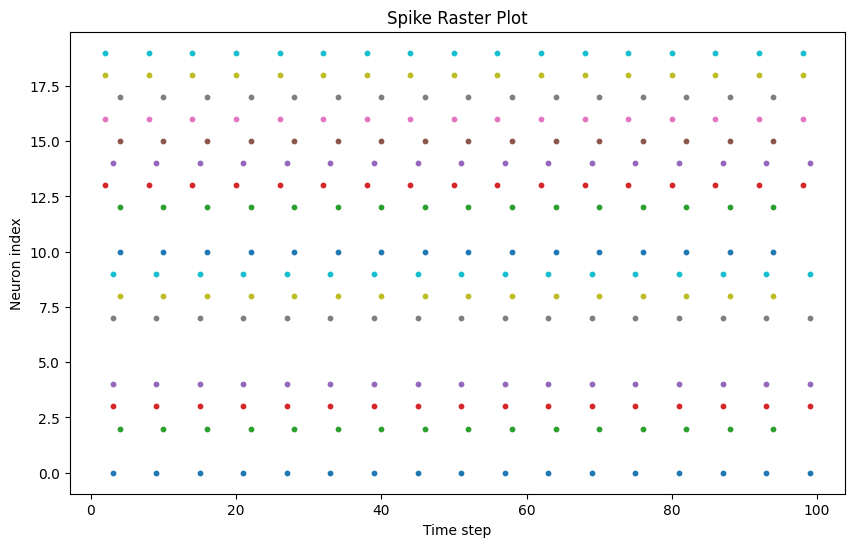

In [15]:
neuron_params = {
    "rest_voltage": 0,
    "threshold": 2,
    "time_constant": 10,
    "refractoriness_time": 3
}

# Instantiate network
net = SNN(
    N=20,
    exc_ratio=0.8,
    in_dim=4,
    out_dim=3,
    **neuron_params
)

# SNN ATTRIBUTES
print("\n===== SNN ATTRIBUTES =====")
print("N:", net.N)
print("Input dim:", net.in_dim)
print("Output dim:", net.out_dim)
print("\n-- Interfaces --")
print("Input interface indices:", net.in_interface)
print("Output interface indices:", net.out_interface)

# Run test
spikes = run_snn_test(net, T=100, input_mode="constant")
# Visualize
plot_spike_raster(spikes)


In [68]:
print("Total spikes:", np.sum(spikes))


Total spikes: 266


### Debug input voltage

In [60]:
def run_voltage_debug(net, T=30, input_value=1):
    """
    Runs network and records voltages of input neurons.
    """

    voltage_history = []
    spike_history = []

    for t in range(T):

        # constant input
        input_data = np.ones(net.in_dim) * input_value

        net.feed_forward(input_data)

        # record only input neuron voltages
        v_snapshot = [
            net.neurons[idx].voltage
            for idx in net.in_interface
        ]

        s_snapshot = [
            net.neurons[idx].sigma
            for idx in net.in_interface
        ]

        voltage_history.append(v_snapshot)
        spike_history.append(s_snapshot)

    return np.array(voltage_history), np.array(spike_history)


In [61]:
def plot_voltage_trace(voltage_history):
    T, n_inputs = voltage_history.shape

    plt.figure(figsize=(10, 6))

    for i in range(n_inputs):
        plt.plot(range(T), voltage_history[:, i], label=f"Input neuron {i}")

    plt.xlabel("Time step")
    plt.ylabel("Membrane voltage")
    plt.title("Input Neuron Voltage Evolution")
    plt.legend()
    plt.show()


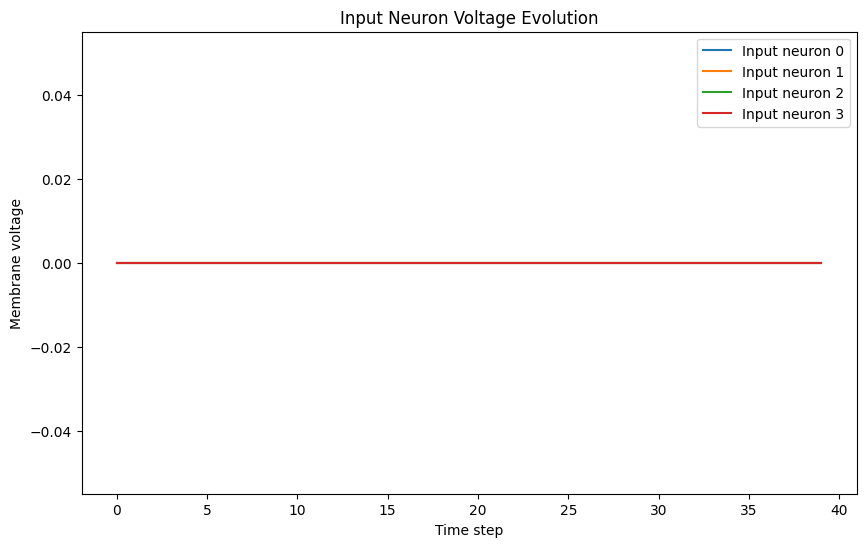

Any spikes in input neurons? 40
Input spikes: 40
Hidden spikes: 0
Output spikes: 0


In [62]:
voltages, spikes = run_voltage_debug(net, T=40, input_value=3)

plot_voltage_trace(voltages)

print("Any spikes in input neurons?",
      np.sum(spikes))

print("Input spikes:", np.sum(spikes[:, :net.in_dim]))
print("Hidden spikes:", np.sum(spikes[:, net.in_dim:net.N-net.out_dim]))
print("Output spikes:", np.sum(spikes[:, net.N-net.out_dim:]))


### Visualizing The Network

Descriminating input/output neurons in rectangles and put all other neurons in 3-D like space.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Rectangle

def plot_snn_graph_with_io_spring(net, max_edges=200, seed=0):
    rng = np.random.default_rng(seed)
    G = nx.DiGraph()
    
    # Add nodes
    for i in range(net.N):
        G.add_node(i)
    
    # Add edges (j → i)
    edges = np.argwhere(net.topology)
    if len(edges) > max_edges:
        edges = edges[rng.choice(len(edges), max_edges, replace=False)]
    for i, j in edges:
        G.add_edge(j, i)
    
    # ---- Initial positions ----
    pos_init = {}
    # Input neurons: left
    for k, n in enumerate(net.in_interface):
        pos_init[n] = np.array([-2.0, k])
    # Output neurons: right
    for k, n in enumerate(net.out_interface):
        pos_init[n] = np.array([2.0, k])
    # Other neurons: random spread
    for n in G.nodes():
        if n not in pos_init:
            pos_init[n] = rng.uniform(-1.0, 1.0, size=2)
    
    # ---- Spring layout with fixed nodes ----
    fixed_nodes = list(net.in_interface) + list(net.out_interface)
    pos = nx.spring_layout(
        G,
        pos=pos_init,
        fixed=fixed_nodes,
        seed=seed,
        k=1.8,          # repulsion distance (tune if needed)
        iterations=300
    )
    
    # ---- Colors ----
    node_colors = [
        "red" if net.if_excitatory[n] else "blue"
        for n in G.nodes()
    ]
    
    fig, ax = plt.subplots(figsize=(11, 9))
    
    # Draw network
    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=420,
        alpha=0.9,
        ax=ax
    )
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle="->",
        arrowsize=10,
        alpha=0.3,
        ax=ax
    )
    nx.draw_networkx_labels(
        G, pos,
        labels={n: str(n) for n in G.nodes()},
        font_size=9,
        ax=ax
    )
    
    # ───────────────────────────────────────────────
    #  Draw rectangle around INPUT nodes
    # ───────────────────────────────────────────────
    if len(net.in_interface) > 0:
        in_nodes_pos = np.array([pos[n] for n in net.in_interface])
        x_min_in, y_min_in = in_nodes_pos.min(axis=0)
        x_max_in, y_max_in = in_nodes_pos.max(axis=0)
        
        # Add some padding
        pad_x = 0.6
        pad_y = 0.5 if len(net.in_interface) > 1 else 0.8
        
        rect_in = Rectangle(
            (x_min_in - pad_x, y_min_in - pad_y),
            width=(x_max_in - x_min_in) + 2 * pad_x,
            height=(y_max_in - y_min_in) + 2 * pad_y,
            linewidth=1.8,
            edgecolor='darkgreen',
            facecolor='none',
            linestyle='--',
            alpha=0.7,
            label="Input layer"
        )
        ax.add_patch(rect_in)
    
    # ───────────────────────────────────────────────
    #  Draw rectangle around OUTPUT nodes
    # ───────────────────────────────────────────────
    if len(net.out_interface) > 0:
        out_nodes_pos = np.array([pos[n] for n in net.out_interface])
        x_min_out, y_min_out = out_nodes_pos.min(axis=0)
        x_max_out, y_max_out = out_nodes_pos.max(axis=0)
        
        pad_x = 0.6
        pad_y = 0.5 if len(net.out_interface) > 1 else 0.8
        
        rect_out = Rectangle(
            (x_min_out - pad_x, y_min_out - pad_y),
            width=(x_max_out - x_min_out) + 2 * pad_x,
            height=(y_max_out - y_min_out) + 2 * pad_y,
            linewidth=1.8,
            edgecolor='darkred',
            facecolor='none',
            linestyle='--',
            alpha=0.7,
            label="Output layer"
        )
        ax.add_patch(rect_out)
    
    # Final touches
    ax.set_title("SNN Connectivity (Spring Layout with I/O groups)\nRed = Excitatory | Blue = Inhibitory")
    ax.axis("off")
    
    # Optional: show legend for the rectangles
    ax.legend(handles=[rect_in, rect_out], loc='upper right', fontsize=10)
    
    plt.tight_layout()
    plt.show()

#### Calling the plot function

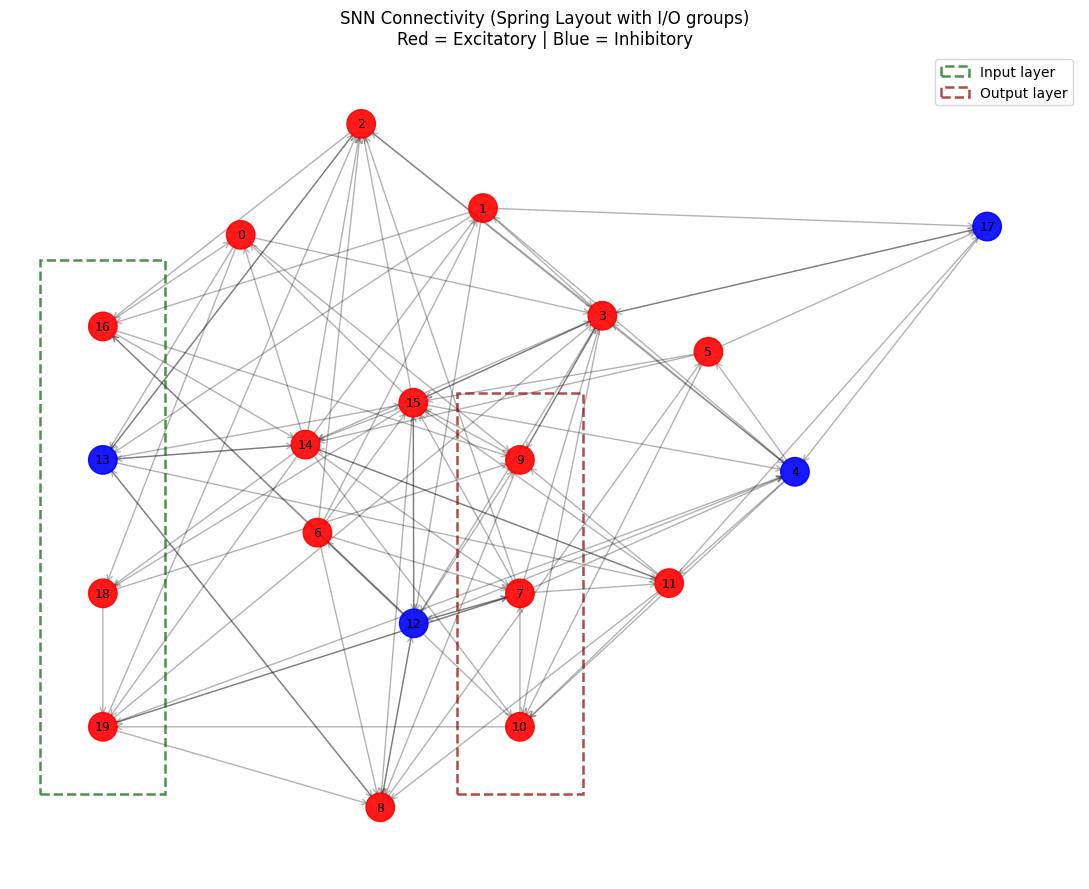

In [26]:
plot_snn_graph_with_io_spring(net, max_edges=300)

### To Do

- problem of firing pattern in network to be inspected

-  the connection init mechanism to be edited

-  input/output layers from the rest to be seperated

-  voltage debugger to be edited , so that voltage after threshold can be seen

- Izhikevich Neuron models to be tested.